In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
train_dir = '/kaggle/input/depression/Dataset/training'
val_dir = '/kaggle/input/depression/Dataset/validation'
test_dir = '/kaggle/input/depression/Dataset/testsets'

In [3]:
def load_images_from_folder(folder, label, img_size=(48, 48)):
    data = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            data.append((img, label))
    return data

def load_dataset(base_path):
    depressed = load_images_from_folder(os.path.join(base_path, 'Depressed'), 1)
    not_depressed = load_images_from_folder(os.path.join(base_path, 'Not Depressed'), 0)
    return depressed + not_depressed

train_data = load_dataset(train_dir)
val_data = load_dataset(val_dir)
test_data = load_dataset(test_dir)


In [4]:
def preprocess_data(data):
    X = np.array([item[0] for item in data]).reshape(-1, 48, 48, 1) / 255.0
    y = np.array([item[1] for item in data])
    return X, y

X_train, y_train = preprocess_data(train_data)
X_val, y_val = preprocess_data(val_data)
X_test, y_test = preprocess_data(test_data)

# One-hot encoding for labels
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [5]:
model = Sequential([
    LSTM(128, input_shape=(48, 48), return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 48, 128)             │          90,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 144,322 (563.76 KB)

 Trainable params: 144,322 (563.76 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [8]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5562 - loss: 0.6846 - val_accuracy: 0.6228 - val_loss: 0.6454
Epoch 2/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6281 - loss: 0.6487 - val_accuracy: 0.6861 - val_loss: 0.5983
Epoch 3/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6689 - loss: 0.6175 - val_accuracy: 0.6854 - val_loss: 0.5885
Epoch 4/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6888 - loss: 0.5955 - val_accuracy: 0.7018 - val_loss: 0.5728
Epoch 5/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7019 - loss: 0.5806 - val_accuracy: 0.6968 - val_loss: 0.5770
Epoch 6/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7251 - loss: 0.5562 - val_accuracy: 0.7220 - val_loss: 0.5495
Epoch 7/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7306 - loss: 0.5384 - val_accuracy: 0.7018 - val_loss: 0.5790
Epoch 8/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7320 - loss: 0.5389 - val_accuracy: 0.

In [9]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8120 - loss: 0.4320
Test Loss: 0.48417872190475464, Test Accuracy: 0.7682279348373413


In [10]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [11]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Not Depressed', 'Depressed']))

Confusion Matrix:
[[615 272]
 [208 976]]
Classification Report:
               precision    recall  f1-score   support

Not Depressed       0.75      0.69      0.72       887
    Depressed       0.78      0.82      0.80      1184

     accuracy                           0.77      2071
    macro avg       0.76      0.76      0.76      2071
 weighted avg       0.77      0.77      0.77      2071



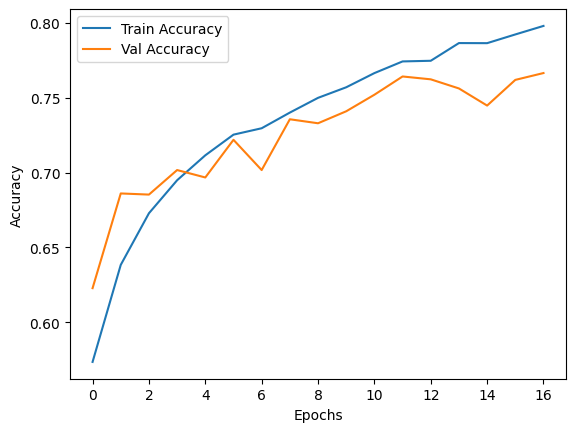

In [12]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

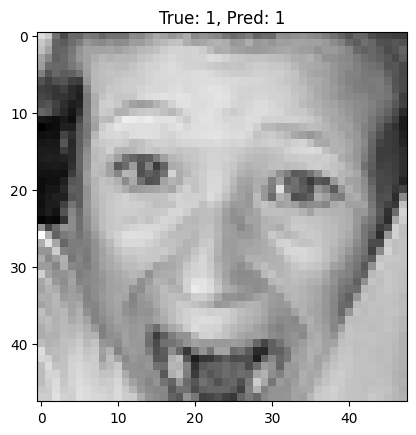

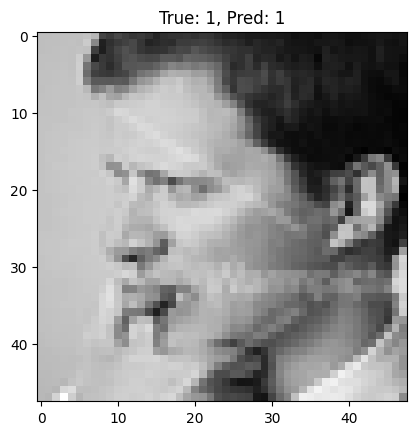

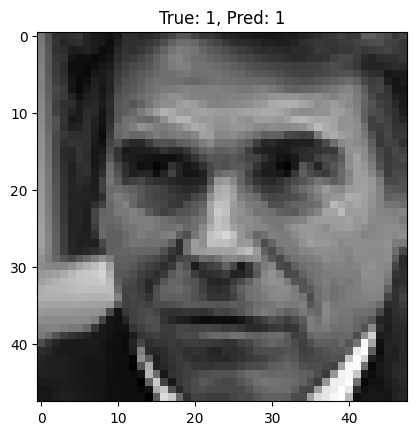

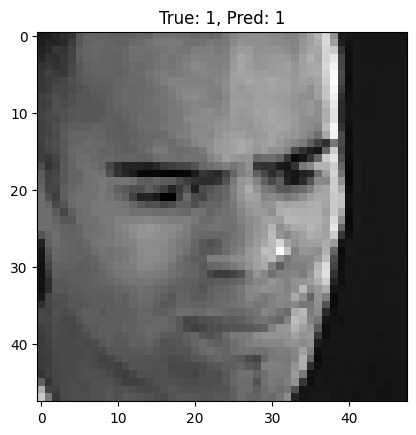

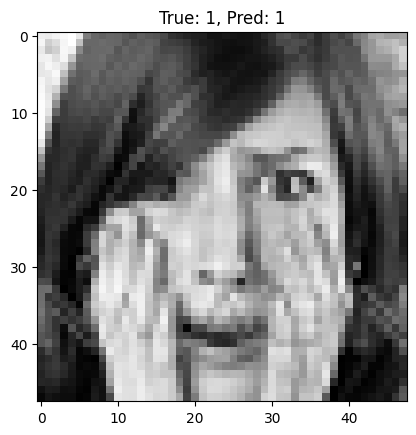

In [13]:
for i in range(5):
    plt.imshow(X_test[i].reshape(48, 48), cmap='gray')
    plt.title(f"True: {y_true[i]}, Pred: {y_pred_classes[i]}")
    plt.show()

In [14]:
model.save('/kaggle/working/depression_lstm_model.h5')